# Random interfaces

The final result of Rob's calculation is that an interface should obey the probability distribution

$$P(\rm curve)\propto \Pi_{n=1}^K \exp\left[\dfrac{\pi^2\gamma}{8 R\phi T}a_n (n^2-1)\right]$$

Tis should provide a recipe to generate 

$$r(\theta) = R+ \sum_{n=1}^K a_n \sin\left(\dfrac{n\pi}{2\phi}(\theta+\phi)\right)$$

Here is a simple implementation.

In [30]:
import numpy as np

def generate_curve(R = 1.0, energy = 1.0, phi = np.pi/2., K = 100,ntheta = 50):
    """
    Generate a random interface.
    
    Parameteres:
        R: radius
        energy: gamma/T
        phi: half-angle
        K: Fourier knots
        ntheta: number of angular evaluations
    """
    
    ns = np.arange(2,K+1, dtype=int)
    variances = 2./( np.pi**2*energy/(8*R*phi)*(ns**2-1))
    stds = np.sqrt(variances)
    # generate all coefficients n>=2
    a2s  = np.array([np.random.normal(0,stds[i]) for i in range(K-1)])
    
    a1 = - np.sum(a2s)
    a = np.concatenate([[a1],a2s]) 
    n = np.concatenate([[1],ns]) 
    #  sample n-2 coefficients
    assert len(a)==K, "Incorrect lengths"
    
    # generate theta range
    theta = np.linspace(-phi,phi,ntheta)
    # calculate sine argument
    prod = np.multiply.outer((theta+phi),n/(2*phi))
    r = np.ones(ntheta)*R+(a*np.sin(prod)).sum(axis=1)

    #impose boundaries
    r[0]=r[-1] = 0
    # get Cartesian coordinates
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x, y,r,theta
    # return prod, a

We then generate some paths

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

areas = []
fig,ax = plt.subplots(1,2)
for k in range(20):
    x,y,r,theta  = generate_curve(phi= np.pi/4, energy = 100, K=1000)
    ax[0].plot(x,y)
    shape = Polygon([(xx,yy) for xx,yy in zip(x,y)])
    areas.append(shape.area)
    print("Area",shape.area)
ax[0].axis('equal');
ax[1].hist(areas);
ax[1].set_xlabel('area')

We can check that shapely is measuring the correct area.

/Users/francesco/.pyenv/versions/3.8.11/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


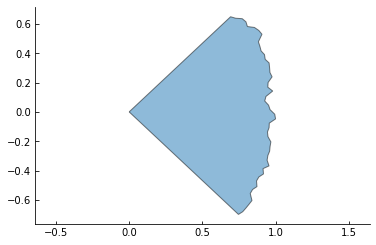

In [33]:
from descartes.patch import PolygonPatch
fig,ax = plt.subplots()
patch = PolygonPatch(shape, alpha=0.5, zorder=2)
ax.add_patch(patch)
ax.axis('equal');